# Estimate rates - Test 1

- test_name = "test_1"

- nsims = 50

- time_max = 20

In [1]:
import numpy as np
import matplotlib.pylab as plt

from scipy.integrate import solve_ivp

import pickle
import sys

In [2]:
sys.path.append("../src/")
from Hypergraphs import CompleteHypergraph
from simulate_gillespie import *
from solve_kolmogorov import *
from estimate_total_rates import *

## Setup

In [3]:
## --- Setup --- ##
test_name = "test_1"

g_type = "complete"

# TODO: increase these values
N = 100
g = CompleteHypergraph(N)

I0 = 1

nsims = 50
run_gillespie_simulations = False

time_max = 20

# selected betas for 3 regimes: .25N, .5N, .75N
betas_unscaled_selected = [(1.778, 2.552), (2.556, 8.241), (5.667, 13.414)]
betas_unscaled = betas_unscaled_selected[2] # TODO: select regime, e.g.: 2 for .75N

beta1 = betas_unscaled[0] / N       # pairwise infection rate
beta2 = betas_unscaled[1] / (N**2)  # hyperedge contagion rate
mu    = 1  # recovery rate

print(f"{test_name}: \n")
print(f"\t H = Complete Hypergraph, N = {N}, I0 = {I0}, time_max = {time_max},")
print(f"\t beta1 * N = {beta1 * N}, beta2 * N^2 = {beta2 * (N**2)}, mu = {mu},")
print(f"\t with estimation based on {nsims} Gillespie simulation runs\n")

test_1: 

	 H = Complete Hypergraph, N = 100, I0 = 1, time_max = 20,
	 beta1 * N = 5.667, beta2 * N^2 = 13.414, mu = 1,
	 with estimation based on 50 Gillespie simulation runs



## Run Gillespie

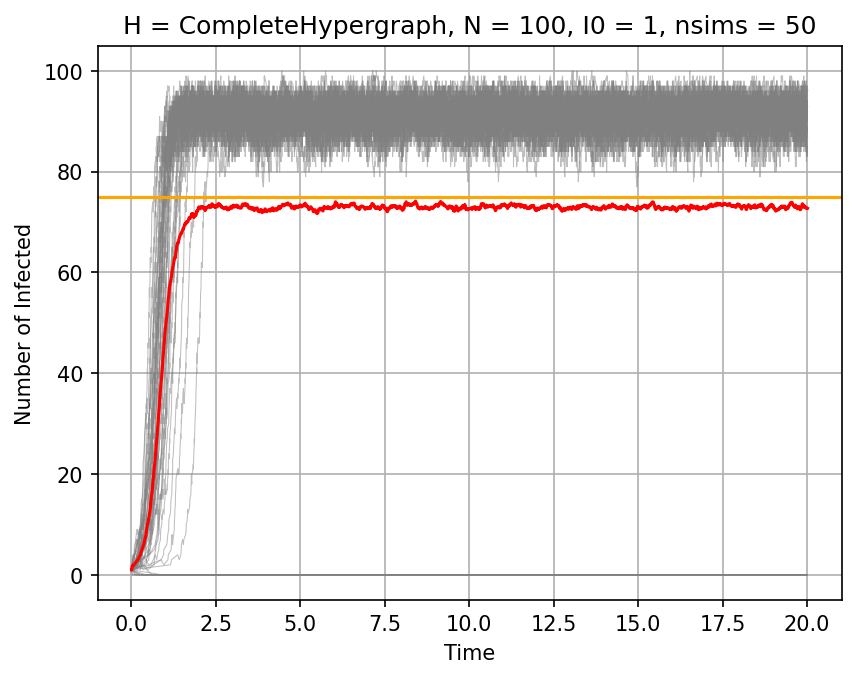

In [4]:
## --- Run Gillespie ---
I0_gillespie = 1 # TODO: go over the range when necessary
initial_infections = list(range(I0_gillespie))

if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim(
            g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="gray", alpha=0.5, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)
# avg_curve, times = get_average_corrected(X_sims, time_max, nsims, delta_t = 0.01)

plt.axhline(y=75, color='orange', linestyle='-')

plt.plot(times, avg_curve, "red")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, I0 = {I0_gillespie}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/complete/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

In [13]:
nsim = 0 # sim 3 died
X_t = X_sims[nsim]
times, times_to_event, infected, event_types, total_pws, total_hos = \
    X_t[0], X_t[1], X_t[2], X_t[3], X_t[4], X_t[5]

df = pd.DataFrame({ 
        "time": times, 
        "time_to_event": times_to_event,
        "infected": infected,
        "event_type": event_types,
        "total_pw": total_pws,
        "total_ho": total_hos,
})
df.head()

,time,time_to_event,infected,event_type,total_pw,total_ho
0,0,None,1,None,99,0
1,0.039688,0.039688,2,PW,196,98
2,0.145832,0.106144,3,PW,291,291
3,0.154404,0.008572,4,PW,384,576
4,0.261706,0.107302,5,PW,475,950


In [14]:
df.tail()

,time,time_to_event,infected,event_type,total_pw,total_ho
3554,19.984064,0.000129,89,PW,979,43076
3555,19.991213,0.007148,88,RC,1056,45936
3556,19.992877,0.001664,89,HO,979,43076
3557,20.00131,0.008433,88,RC,1056,45936
3558,20,0.008433,88,None,None,None


In [15]:
# Single X_t has:
# [time, time_to_event, infected, event_type, total_pw, total_ho]
nsim = 3 # sim 3 died
X_t = X_sims[nsim]
times, times_to_event, infected, event_types, total_pws, total_hos = \
    X_t[0], X_t[1], X_t[2], X_t[3], X_t[4], X_t[5]

df = pd.DataFrame({ 
        "time": times, 
        "time_to_event": times_to_event,
        "infected": infected,
        "event_type": event_types,
        "total_pw": total_pws,
        "total_ho": total_hos,
})
df.head()

,time,time_to_event,infected,event_type,total_pw,total_ho
0,0,None,1,None,99,0
1,0.308838,0.154419,0,RC,None,None
2,20,0.154419,0,None,None,None


## Solve KEs and compare

p0 = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


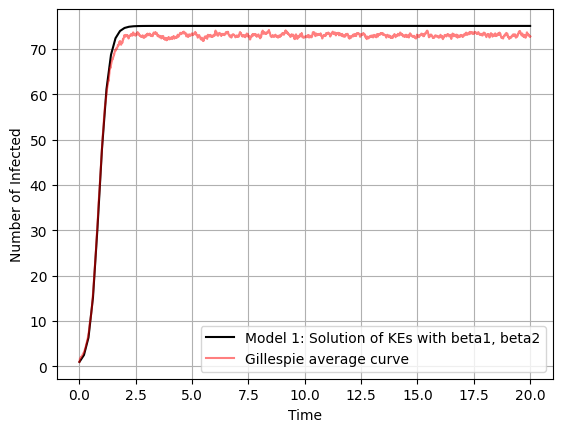

In [6]:
## --- Solve KEs and compare ---
M = N + 1
all_states = list_all_states(g)

# set the initial condition
p0 = np.zeros(M)
p0[I0] = 1.0 # all other states have prob 0 at time 0
print(f"p0 = {p0[:20]} ...")

# time range and times to evaluate solution
nsteps = 101
t_span = (0.0, time_max)
t_eval = np.linspace(t_span[0], t_span[1], nsteps)    

ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)
def f_ode(t, p):
    return ode_system_complete(t, p)
sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")
expected_values = calculate_expected_values(sol)

plt.figure()
plt.plot(sol.t, expected_values, color="k", label="Model 1: Solution of KEs with beta1, beta2")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.savefig(f"../figures/estimation/complete/{test_name}/solution-of-KEs.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Calculate the estimates

In [7]:
## --- Calculate the estimates ---
min_Tk_threshold = 1e-6
estimates = calculate_estimates(X_sims, N, min_Tk_threshold)

Skipping: duration = -0.001309990560685037, event_index = None, index = 3557, sim = 0
Skipping: duration = -0.0018650584152766214, event_index = None, index = 3578, sim = 2
Skipping: duration = -0.0034304763441816988, event_index = None, index = 3636, sim = 4
Skipping: duration = -0.003429974878660147, event_index = None, index = 3580, sim = 6
Skipping: duration = -0.004576877573231997, event_index = None, index = 3630, sim = 7
Skipping: duration = -0.007194993068317501, event_index = None, index = 3633, sim = 10
Skipping: duration = -3.326843665263368e-05, event_index = None, index = 3505, sim = 11
Skipping: duration = -0.001770156925275046, event_index = None, index = 3593, sim = 13
Skipping: duration = -0.002899645068723089, event_index = None, index = 3501, sim = 14
Skipping: duration = -0.0032965163916536255, event_index = None, index = 3683, sim = 15
Skipping: duration = -0.0049708107629093945, event_index = None, index = 3580, sim = 16
Skipping: duration = -0.0004747323871328035

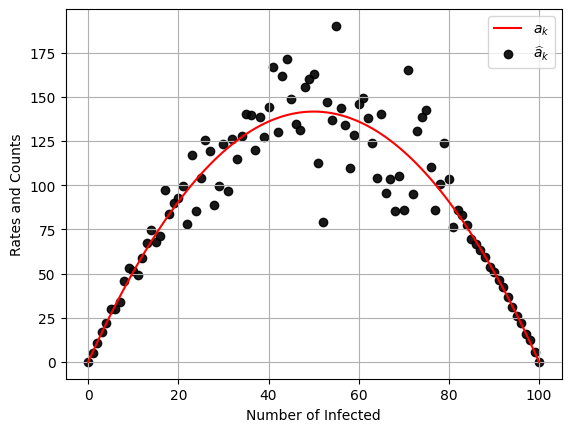

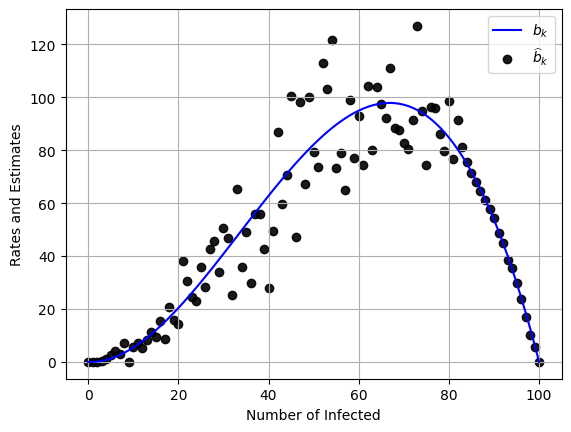

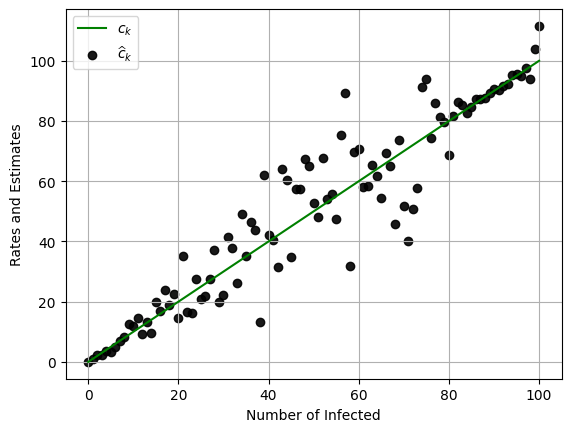

In [8]:
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]
c_k_hat = estimates["c_k_hat"]

# plot only where T_k was non-zero!
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

# and compare them to theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))
a_k = beta1 * k_values * (N - k_values)
b_k = beta2 * k_choose_2 * (N - k_values)
c_k = mu * k_values

fig = plt.figure()
ax = plt.subplot()

# theoretical ak vs. ak hats 
ax.plot(k_values, a_k, label=r'$a_k$', color="red")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/complete/{test_name}/estimates_ak.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

# theoretical bk vs. bk hats
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx],
        label=r'$\widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/complete/{test_name}/estimates_bk.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

# theoretical ck vs. ck hats (as a test only)
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, c_k, label=r'$c_k$', color="green")
ax.scatter(k_values[valid_k_idx], c_k_hat[valid_k_idx],
        label=r'$\widehat{c}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/complete/{test_name}/estimates_ck.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

## Solve KEs using the estimates 

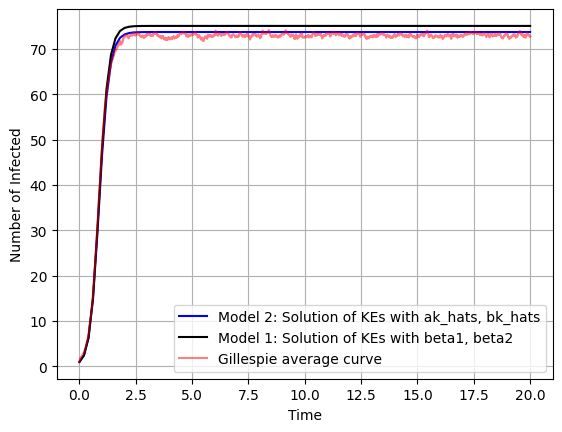

In [9]:
## --- Solve KEs using the estimates and compare ---
# --- Model 2 ---
ode_system_complete = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol_hat = solve_ivp(f_ode, 
                    t_span, 
                    p0, 
                    t_eval=t_eval,
                    method="LSODA")

expected_values_hat = calculate_expected_values(sol_hat)
plt.figure()

plt.plot(sol.t, expected_values_hat, color="b", label="Model 2: Solution of KEs with ak_hats, bk_hats")
# plt.scatter(sol.t, expected_values_hat, color="b", s=10, alpha=.8, label="Model 2: Solution of KEs with ak_hats, bk_hats")

plt.plot(sol.t, expected_values, color="k", label="Model 1: Solution of KEs with beta1, beta2")



plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.savefig(f"../figures/estimation/complete/{test_name}/solutions-comparison.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()